In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory, get_file, load_img, img_to_array
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Préparation des données

Les images contenues dans le dossier original _flowers_ ont été réparties à la main entre deux sous-dossiers _train_ et _validation_ contenant respectivement les données servant à l'apprentissage et à la validation. Chacun de ces sous-dossiers contient à son tour 5 dossiers portant le nom des types de fleurs à classifier : _daisy_, _dandelion_, _rose_, _sunflower_ et _tulip_.

Pour la répartition, on s'est contenté d'extraire les premières images des dossiers de base pour les placer dans _validation_, de sorte à ce que ses sous-dossiers contiennent environ 20% des images d'origine, les 80% restant constituant le dossier _train_.

In [3]:
dossier = "flowers"
fl_train = image_dataset_from_directory(dossier+"/train", label_mode="categorical", shuffle=False)
fl_valid = image_dataset_from_directory(dossier+"/validation", label_mode="categorical", shuffle=False)

Found 3457 files belonging to 5 classes.
Found 860 files belonging to 5 classes.


Les données ont été importées sous forme de dataset Tensorflow grâce à la fonction `image_dataset_from_directory` (conseillée en remplacement d'`ImageDataGenerator` que nous avions déjà utilisée).

Nous avons gardé le redimensionnement par défaut qui adapte les images en entrée au format 256\*256 ainsi que le découpage par défaut des données en batches de 32 images.

Les étiquettes associées aux images sont déduites automatiquement des dossiers qui les contiennent. L'option `label_mode="categorical"` permet de les conserver dans le dataset sous forme de vecteurs _one-hot_.

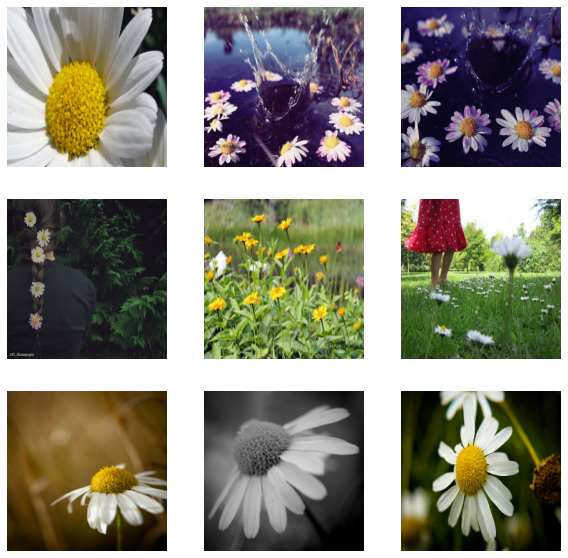

In [4]:
# Visualisation de quelques données

plt.figure(figsize=(10, 10))
for image, label in fl_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.axis('off')
plt.show()

Afin de nous faciliter la tâche, on sépare les données et leurs étiquettes en recourant à une compréhension de liste (l'objet `dataset` se comportant comme un générateur) associé à la fonction `concatenate` de Numpy pour convertir le tout en tableau de données Numpy.

In [5]:
im_train = np.concatenate([x for x, y in fl_train], axis=0)
lab_train = np.concatenate([y for x, y in fl_train], axis=0)
im_valid = np.concatenate([x for x, y in fl_valid], axis=0)
lab_valid = np.concatenate([y for x, y in fl_valid], axis=0)

# Création du réseau

Le réseau pré-entraîné choisi est __EfficientNet__ dans sa version B0, soit la plus basique. Ce réseau développé par Google a pour particularité d'être léger et d'atteindre rapidement de bonnes performances en termes d'exactitude.

A noter également que contrairement à d'autres réseaux qui nécessitent une préparation des données à la main ou via des fonctions `preprocess_input()`, l'architecture EfficientNet proposée par Tensorflow intègre des couches de prétraitement. __Il n'est donc pas utile ici de procéder à une normalisation ou au passage de RGB à BGR.__

In [6]:
# On prend soin de supprimer les couches finales pour ne conserver que la génération de features
effNet = EfficientNetB0(include_top=False)

In [7]:
# Un simple forward-pass dans le réseau tronqué permet d'obtenir les features correspondantes
# Compter 2 à 3 minutes pour l'exécution
train_features = effNet.predict(im_train)
valid_features = effNet.predict(im_valid)

27/27 [==============================] - 26s 952ms/step


In [8]:
train_features.shape

(3457, 8, 8, 1280)

Chaque image donnée au réseau est décomposée en 1280 features de taille 8x8.

Le nouveau dataset ainsi obtenu servira ensuite de couche d'entrée à notre propre petit réseau _fully-connected_ afin de classifier nos images.

In [9]:
entree = layers.Input(shape=train_features.shape[1:])
x = layers.Flatten(input_shape=train_features.shape[1:])(entree)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
y = layers.Dense(5, activation='softmax')(x) # sortie sous forme one-hot (vecteur de taille 5)

model = Model(entree, y)

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [11]:
model.fit(train_features, lab_train,
         epochs=10, # On se contente de peu d'epochs dans la mesure où notre réseau d'ajuste rapidement
         batch_size=32,
         validation_data=(valid_features, lab_valid))

Epoch 1/10
109/109 [==============================] - 12s 94ms/step - loss: 1.3429 - acc: 0.7035 - val_loss: 0.4391 - val_acc: 0.8709
Epoch 2/10
109/109 [==============================] - 10s 92ms/step - loss: 0.8590 - acc: 0.8354 - val_loss: 0.4532 - val_acc: 0.8744
Epoch 3/10
109/109 [==============================] - 10s 92ms/step - loss: 0.5139 - acc: 0.8727 - val_loss: 0.4545 - val_acc: 0.8907
Epoch 4/10
109/109 [==============================] - 10s 92ms/step - loss: 0.3911 - acc: 0.9043 - val_loss: 0.4315 - val_acc: 0.8733
Epoch 5/10
109/109 [==============================] - 10s 92ms/step - loss: 0.2416 - acc: 0.9297 - val_loss: 0.4620 - val_acc: 0.8791
Epoch 6/10
109/109 [==============================] - 10s 92ms/step - loss: 0.2183 - acc: 0.9416 - val_loss: 0.4379 - val_acc: 0.9000
Epoch 7/10
109/109 [==============================] - 10s 92ms/step - loss: 0.1677 - acc: 0.9526 - val_loss: 0.5903 - val_acc: 0.8988
Epoch 8/10
109/109 [==============================] - 10s 92ms

# Evaluation

In [12]:
print(f"Exactitude obtenue sur l'ensemble de validation : {round(model.evaluate(valid_features, lab_valid, verbose=0)[1]*100, 2)}%")

Exactitude obtenue sur l'ensemble de validation : 89.77%


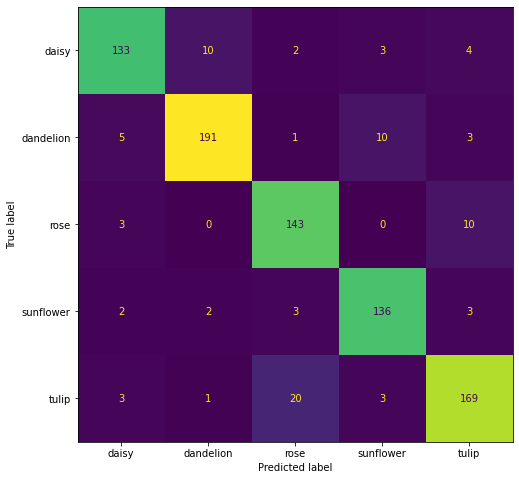

In [13]:
# Matrice de confusion

# On prédit le type de fleur à partir des features tirées de l'ensemble de validation
pred = model.predict(valid_features, verbose=0)

# Pour chaque observation, on sélectionne le rang de la valeur la plus élevée pour défaire l'encodage one-hot
pred = np.argmax(pred, axis=1)

# On peut ensuite procéder de même sur les étiquettes vraies pour obtenir la matrice de confusion
conf_mat = confusion_matrix(np.argmax(lab_valid, axis=1), pred)
cm = ConfusionMatrixDisplay(conf_mat, display_labels=fl_train.class_names)
# Augmentation de la taille
fig, ax = plt.subplots(figsize=(8,8))
cm.plot(ax=ax, colorbar=False)

# Test sur de nouvelles images

In [34]:
# Marguerites
l0 = "https://www.botanix.com/gpc/_media/Image/201638154915/chrysanthemum-marguerite-becky-plante-vivace-soleil_660x0.jpg"
l1 = "https://www.les-sauvages-pepiniere.com/wp-content/uploads/leucanthemum_vulgare_cat.jpg"

# Pissenlits
l2 = "https://jardinage.lemonde.fr/images/dossiers/historique/pissenlit1-171337.jpg"
l3 = "https://medias.pourlascience.fr/api/v1/images/view/5be9a2ea3e45464420600eec/wide_1300/image.jpg"

# Roses
l4 = "https://bergamotte.imgix.net/hbcni7qatpatmbahknsavaxp55m7?ixlib=rails-4.2.0&auto=format%2Ccompress&fit=crop&q=65&ar=1%3A1"
l5 = "https://static.aujardin.info/cache/th/img9/rosa-fleur-600x450.jpg"

# Tournesols
l6 = "https://jardinage.lemonde.fr/images/dossiers/historique/tournesol-175148.jpg"
l7 = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d8/Helianthus_annuus_0001.JPG/800px-Helianthus_annuus_0001.JPG"

# Tulipes
l8 = "https://jardinage.lemonde.fr/images/dossiers/2020-03/tulipe-135728.jpg"
l9 = "https://www.gammvert.fr/conseils/sites/default/files/styles/main_image/public/2019-09/Fotolia_73611326_L-resize.jpg?itok=rfOdC4KL"

L = [l7, l8, l4, l5, l1, l9, l6, l2, l0, l3]

In [35]:
# On prépare un array vide aux dimensions des futures images importées
im_test = np.empty((10, 256, 256, 3))

for i, link in enumerate(L):
    name = f'img{i}'
    # La fonction get_file permet d'obenir l'image depuis son url et load_img de la charger en mémoire
    # On reprend le dimensionnement par défaut de la fonction image_dataset_from_directory
    img = load_img(get_file(name, link), target_size=(256, 256)) 
    # On convertit l'image brute en array numpy
    img_arr = img_to_array(img)
    img_arr = np.expand_dims(img_arr, 0)
    im_test[i] = img_arr

147027/147027 [==============================] - 0s 0us/step


In [36]:
# On passe les nouvelles données à travers EfficientNet pour extraire les features
test_features = effNet.predict(im_test, verbose=0)

# On prédit ensuite la classe des nouvelles images à partir de notre modèle ajusté
pred_test = model.predict(test_features)

# On remplace l'encodage one-hot par une valeur numérique allant de 0 à 4
pred_test = np.argmax(pred_test, axis=1)

1/1 [==============================] - 0s 18ms/step


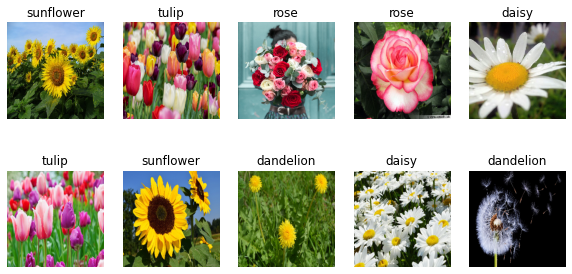

In [37]:
plt.figure(figsize=(10, 5))
for i, img in enumerate(im_test):
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(img.astype('uint8'))
    classe_predite = pred_test[i]
    plt.title(fl_train.class_names[classe_predite])
    plt.axis('off')
plt.show()

__En affichant les nouvelles images de fleurs avec leur catégorie d'appartenance prédite, on constate la relative efficacité de notre modèle.__